In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import jax.random as jr
import jax.numpy as np

from ssm.ctlds.base import CTLDS
from ssm.ctlds.models import GaussianCTLDS

import ssm.ctlds.initial as initial
import ssm.ctlds.dynamics as dynamics
import ssm.ctlds.emissions as emissions

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec 

from ssm.plots import plot_continuous_dynamics_2d


def plot_emissions(states, data):
    latent_dim = states.shape[-1]
    emissions_dim = data.shape[-1]
    num_timesteps = data.shape[0]
    
    plt.figure(figsize=(8, 6))
    gs = GridSpec(2, 1, height_ratios=(1, emissions_dim / latent_dim))

    # Plot the continuous latent states
    lim = abs(states).max()
    plt.subplot(gs[0])
    for d in range(latent_dim):
        plt.plot(states[:, d] + lim * d, '-')
    plt.yticks(np.arange(latent_dim) * lim, ["$x_{}$".format(d+1) for d in range(latent_dim)])
    plt.xticks([])
    plt.xlim(0, num_timesteps)
    plt.title("Sampled Latent States")

    lim = abs(data).max()
    plt.subplot(gs[1])
    for n in range(emissions_dim):
        plt.plot(data[:, n] - lim * n, '-k')
    plt.yticks(-np.arange(emissions_dim) * lim, ["$y_{{ {} }}$".format(n+1) for n in range(emissions_dim)])
    plt.xlabel("time")
    plt.xlim(0, num_timesteps)

    plt.title("Sampled Emissions")
    plt.tight_layout()
    

def plot_dynamics(ctlds, states, figsize=(5, 5)):
    fig = plt.figure(figsize=figsize)
    q = plot_continuous_dynamics_2d(drift_matrix=ctlds.drift_matrix, 
                                    drift_bias=ctlds.drift_bias,
                                    mins=states.min(axis=0),
                                    maxs=states.max(axis=0),
                                    color="blue")
    plt.plot(states[:,0], states[:,1], lw=2, label="Latent State")
    plt.plot(states[0,0], states[0,1], '*r', markersize=10, label="Initial State")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title("Latent States & Dynamics")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

In [3]:
latent_dim = 2
emissions_dim = 3
seed = jr.PRNGKey(0)

# Build the components of the CTLDS

# # 1) Initial
# initial_state_mean = np.zeros(latent_dim)
# initial_state_scale_tril = np.eye(latent_dim) * 0.01
# myInitial = initial.StandardInitialCondition(initial_state_mean, initial_state_scale_tril)

# # 2) Dynamics
# drift_matrix = np.array([[-1, -1], 
#                          [1, -1]])
# diffusion_scale = np.eye(latent_dim) * 0.1
# drift_bias = np.zeros((latent_dim,))
# myDynamics = dynamics.StationaryCTDynamics(drift_matrix, drift_bias, diffusion_scale)

# # 3) Emissions
# emission_weights = jr.normal(seed, shape=(emission_dim, latent_dim))
# emission_bias = np.zeros((emission_dim,))
# emission_scale_tril = 0.1**2 * np.eye(emission_dim)

# myEmissions = emissions.GaussianEmissions(
#     weights=emission_weights,
#     bias=emission_bias,
#     scale_tril=emission_scale_tril
# )

# # Construct the CTLDS
# ctlds = CTLDS(myInitial, myDynamics, myEmissions)

true_ctlds = GaussianCTLDS(num_latent_dims=latent_dim,
                           num_emission_dims=emissions_dim,
                           seed=seed)

In [11]:
# sample 5 independent trials each 200 timesteps long
num_trials = 5
num_timesteps = 200
rng = jr.PRNGKey(0)

# parameterized by the relative time difference between observations 
rng, seed = jr.split(rng)
covariates = jr.uniform(seed, shape=(num_trials, num_timesteps)) + 0.1

all_states, all_data = true_ctlds.sample(key=rng,
                                         covariates=covariates,
                                         num_steps=num_timesteps,
                                         num_samples=num_trials)

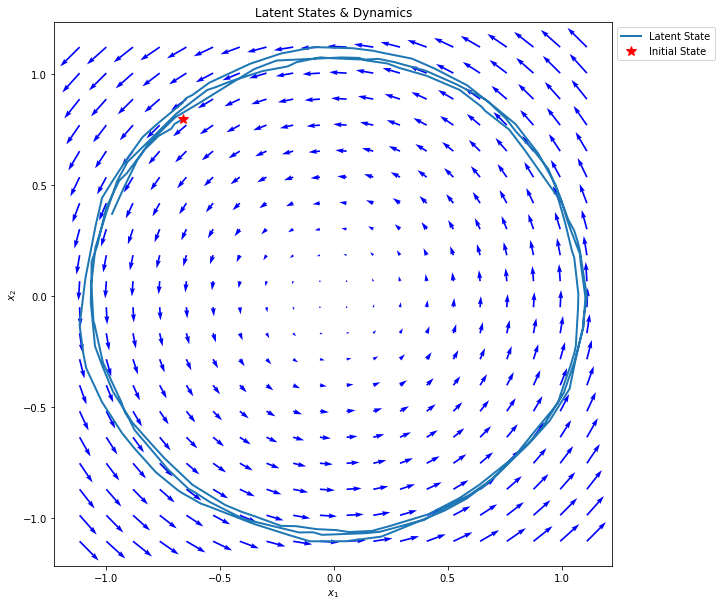

In [12]:
plot_dynamics(true_ctlds, all_states[0], figsize=(10, 10))

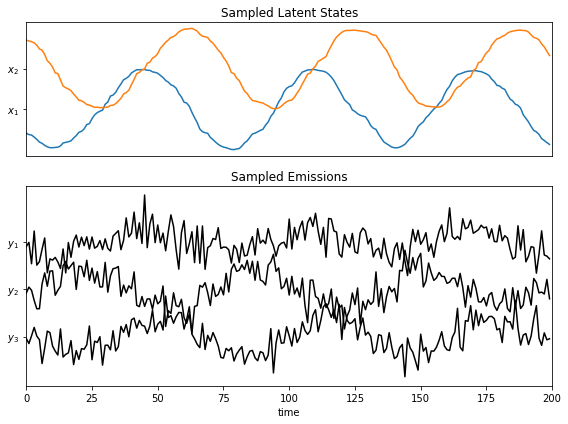

In [13]:
plot_emissions(all_states[0], all_data[0])

## Inference: fit a CTLDS to synthetic data

In [15]:
# define some parameters for our test_lds
seed = jr.PRNGKey(32)  # different random seed!

# initialize our test lds model
test_lds = GaussianCTLDS(num_latent_dims=latent_dim,
                         num_emission_dims=emissions_dim,
                         seed=seed)

In [ ]:
lps, fitted_ctlds, posteriors = test_lds.fit(all_data, covariates, method='em')